In [76]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Flatten, Reshape, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

import seaborn as sns
import numpy as np
import os
import pandas as pd
import pywt

In [122]:
epoch_num = 5
sequence_length = 8  # Number of time steps to consider

# Define file and directory names
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
# parent_dir = 'forexPredictor'
# repo = 'Repos_git'
# repo_dir = 'Make_Money_with_Tensorflow_2.0'
# Get the absolute base directory dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Move up one level

# Construct the full file path in an OS-independent way
# data_path = os.path.join(base_dir, repo, repo_dir, parent_dir, data_dir, file_name)
data_path = os.path.join(base_dir, data_dir, file_name)

# Check if the file exists before using it
if os.path.exists(data_path):
    print(f"✅ File found: {data_path}")
else:
    print(f"❌ Error: File not found at {data_path}")


ucols=['Open', 'High', 'Low', 'Close']
data_main = pd.read_csv(data_path, usecols=ucols)
data_main.reset_index(drop=True, inplace=True)
data_main.head()


✅ File found: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\0_61938.csv


,Open,High,Low,Close
0,1.20997,1.21089,1.20966,1.20999
1,1.20481,1.20569,1.20479,1.20538
2,1.20537,1.20574,1.20341,1.20553
3,1.20556,1.20689,1.20442,1.20469
4,1.20468,1.20599,1.20380,1.20573


In [123]:
df = data_main.iloc[20000:30000]
# Convert DataFrame to NumPy array
# data = df.values

<Axes: >

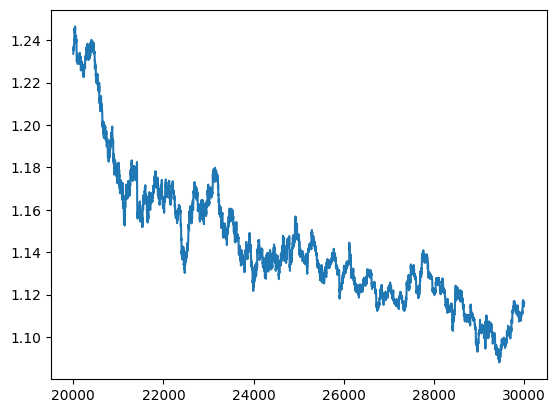

In [6]:
df['Close'].plot()

In [124]:
# Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)


In [107]:
df_scaled.shape

(10000, 4)

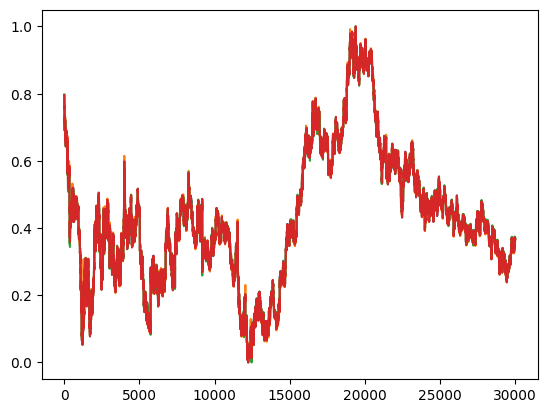

In [9]:
plt.plot(df_scaled)

In [125]:
# Convert Data into Time Series Sequences
def create_sequences(data, time_steps=30):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])  # Past 30 days as input
        labels.append(1 if data[i + time_steps][-1] > data[i + time_steps - 1][-1] else 0)  # Binary trend label
    return np.array(sequences), np.array(labels)

In [126]:
time_steps = 30
X, y = create_sequences(df_scaled, time_steps)


In [127]:
print(df_scaled.shape, X.shape, y.shape)

(10000, 4) (9970, 30, 4) (9970,)


In [128]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [129]:
def create_autoencoder_decoder():
    # Define Autoencoder Model
    latent_dim = 16
    input_layer = Input(shape=(time_steps, df_scaled.shape[1]))  # Adjust input shape to match X.shape

    # Encoder
    encoded = LSTM(64, activation="relu", return_sequences=True)(input_layer)
    encoded = LSTM(latent_dim, activation="relu", return_sequences=False)(encoded)

    # Decoder
    decoded = RepeatVector(30)(encoded)
    decoded = LSTM(64, activation="relu", return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(df_scaled.shape[1]))(decoded)  # Output should also match input (2 features)

    # Autoencoder Model
    autoencoder = Model(input_layer, decoded)
    
    # Extract the encoder part from the autoencoder model
    encoder = Model(autoencoder.input, autoencoder.layers[2].output)
    autoencoder.compile(optimizer="adam", loss="mse")

    return autoencoder, encoder

# Create and Train Autoencoder
auto_encoder, encoder = create_autoencoder_decoder()
auto_encoder.fit(X_train, X_train, epochs=5, batch_size=32, verbose=1)


Epoch 1/5
250/250 [==============================] - 19s 49ms/step - loss: 0.0241
Epoch 2/5
250/250 [==============================] - 12s 49ms/step - loss: 4.1396e-04
Epoch 3/5
250/250 [==============================] - 12s 49ms/step - loss: 2.0340e-04
Epoch 4/5
250/250 [==============================] - 12s 49ms/step - loss: 1.9251e-04
Epoch 5/5
250/250 [==============================] - 12s 49ms/step - loss: 1.7763e-04


In [130]:
# Transform Data into Latent Features
features = encoder.predict(X_train)

print("Extracted Features Shape:", features.shape, X_train.shape)  # Expected: (num_samples, latent_dim)

250/250 [==============================] - 4s 12ms/step
Extracted Features Shape: (7976, 16) (7976, 30, 4)


In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict reconstructed sequences
X_train_pred = auto_encoder.predict(X_train)
X_test_pred = auto_encoder.predict(X_test)

# Compute MSE, MAE, and R²
mse_train = mean_squared_error(X_train.flatten(), X_train_pred.flatten())
mae_train = mean_absolute_error(X_train.flatten(), X_train_pred.flatten())
r2_train = r2_score(X_train.flatten(), X_train_pred.flatten())

mse_test = mean_squared_error(X_test.flatten(), X_test_pred.flatten())
mae_test = mean_absolute_error(X_test.flatten(), X_test_pred.flatten())
r2_test = r2_score(X_test.flatten(), X_test_pred.flatten())

# Print Performance Metrics
print(f"Train MSE: {mse_train:.4f}, Train MAE: {mae_train:.4f}, Train R²: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.4f}, Test MAE: {mae_test:.4f}, Test R²: {r2_test:.4f}")


63/63 [==============================] - 1s 18ms/step
Train MSE: 0.0002, Train MAE: 0.0094, Train R²: 0.9958
Test MSE: 0.0002, Test MAE: 0.0095, Test R²: 0.9960


In [132]:
# Apply TimeSeriesKMeans with Dynamic Time Warping (DTW)
n_clusters = 3  # Buy (1), Sell (-1), Hold (0)
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
clusters = kmeans.fit_predict(features)

print("Cluster Labels:", np.unique(clusters, return_counts=True))  # Check cluster distribution

# Map Clusters to Trading Decisions
cluster_labels = {0: -1, 1: 0, 2: 1}  # Assign Sell (-1), Hold (0), Buy (1)
y_clustered = np.array([cluster_labels[c] for c in clusters])

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, y_clustered)

print("Balanced Class Distribution:", np.unique(y_resampled, return_counts=True))

Cluster Labels: (array([0, 1, 2], dtype=int64), array([2173, 5316,  487], dtype=int64))
Balanced Class Distribution: (array([-1,  0,  1]), array([5316, 5316, 5316], dtype=int64))


In [133]:
print(X_resampled.shape, y_resampled.shape, features.shape)

(15948, 16) (15948,) (7976, 16)


In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# One-hot encode the labels
encoder_onehot = OneHotEncoder(sparse=False)
y_encoded = encoder_onehot.fit_transform(y_resampled.reshape(-1, 1))

print("One-Hot Encoded Labels Shape:", y_encoded.shape)

# Reshape X to match MLP input requirements
X_resampled_reshaped = X_resampled.reshape((-1, X_resampled.shape[1]))  # (samples, features)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled_reshaped, y_encoded, test_size=0.2, random_state=42)

# Define MLP Model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_encoded.shape[1], activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile Model
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train MLP Model
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions & Evaluation
y_pred = mlp_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes))


One-Hot Encoded Labels Shape: (15948, 3)
Epoch 1/10


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


399/399 [==============================] - 3s 5ms/step - loss: 0.2442 - accuracy: 0.9128 - val_loss: 0.0339 - val_accuracy: 0.9959
Epoch 2/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0504 - accuracy: 0.9850 - val_loss: 0.0233 - val_accuracy: 0.9893
Epoch 3/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0378 - accuracy: 0.9871 - val_loss: 0.0101 - val_accuracy: 0.9997
Epoch 4/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0295 - accuracy: 0.9898 - val_loss: 0.0081 - val_accuracy: 0.9972
Epoch 5/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0254 - accuracy: 0.9901 - val_loss: 0.0167 - val_accuracy: 0.9903
Epoch 6/10
399/399 [==============================] - 2s 4ms/step - loss: 0.0204 - accuracy: 0.9922 - val_loss: 0.0074 - val_accuracy: 0.9969
Epoch 7/10
399/399 [==============================] - 1s 4ms/step - loss: 0.0201 - accuracy: 0.9924 - val_loss: 0.0098 - val_accuracy: 0.9947
Epoch 8/10
399/39

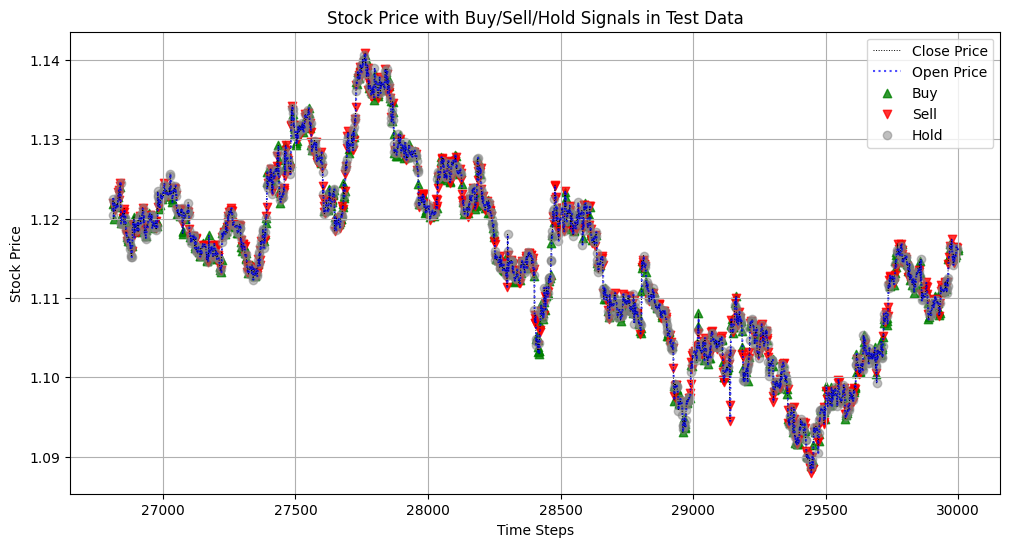

In [135]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure indices align correctly
df_test = df.iloc[-len(X_test):].copy()  # Copy test data portion

# Convert predicted classes to Pandas Series
y_pred_classes = y_pred.argmax(axis=1)  # Assuming y_pred is one-hot encoded
y_pred_series = pd.Series(y_pred_classes, index=df_test.index)

# Map class labels back to Buy, Sell, Hold
label_mapping = {2: 1, 1: -1, 0: 0}  # Assuming 2=Buy, 1=Sell, 0=Hold
y_pred_series = y_pred_series.map(label_mapping)

# Plot OHLC Data
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test["Close"], label='Close Price', linestyle='dotted', linewidth=0.7, color="black")
plt.plot(df_test.index, df_test["Open"], label='Open Price', linestyle='dotted', alpha=0.7, color="blue")

# Find Buy, Sell, Hold signals
buy_signals = df_test.index[y_pred_series == 1]
sell_signals = df_test.index[y_pred_series == -1]
hold_signals = df_test.index[y_pred_series == 0]

# Plot Signals on Close Price
plt.scatter(buy_signals, df_test.loc[buy_signals, "Close"], marker='^', color='green', label='Buy', alpha=0.8)
plt.scatter(sell_signals, df_test.loc[sell_signals, "Close"], marker='v', color='red', label='Sell', alpha=0.8)
plt.scatter(hold_signals, df_test.loc[hold_signals, "Close"], marker='o', color='gray', label='Hold', alpha=0.5)

plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price with Buy/Sell/Hold Signals in Test Data")
plt.grid(True)
plt.show()


In [136]:
# documentation: https://www.mql5.com/en/docs/integration/python_metatrader5

import MetaTrader5 as mt  # pip install MetaTrader5
import pandas as pd  # pip install pandas
from datetime import datetime, timedelta
import os

# start the platform with initialize()
mt.initialize()

# login to Trade Account with login()
# make sure that trade server is enabled in MT5 client terminal

login = 165905041
password = 'iIeElL0176_'
server = 'XMGlobal-MT5 2'

mt.login(login, password, server)



# Define symbol and timeframe
symbol = "EURUSD"
timeframe = mt.TIMEFRAME_H1

# Get data for the last 48 hours
end_time = datetime.now()
start_time = end_time - timedelta(hours=1000)

# Retrieve OHLC data
ohlc_data = pd.DataFrame(mt.copy_rates_range(symbol, timeframe, start_time, end_time))

# Convert time column to datetime format
ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')


ohlc_data.rename(columns={'open':'Open', 'high':'High', 
                        'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
columns_to_drop = ['time', 'spread', 'real_volume', 'Volume']
ohlc_data.drop(columns=[col for col in columns_to_drop if col in ohlc_data.columns], inplace=True)

ohlc_data.head()

,Open,High,Low,Close
0,1.04440,1.04539,1.04406,1.04513
1,1.04515,1.04661,1.04509,1.04654
2,1.04655,1.04686,1.04530,1.04557
3,1.04556,1.04557,1.04382,1.04451
4,1.04451,1.04470,1.04342,1.04431


In [143]:
new_df = ohlc_data

In [144]:
new_df.shape

(712, 4)

In [145]:
new_df_scaled = scaler.transform(ohlc_data)
new_df_scaled_X, new_df_scaled_y = create_sequences(new_df_scaled, time_steps)


In [146]:
print(X_test.shape, new_df_scaled_X.shape, new_df_scaled_y.shape)

(3190, 16) (682, 30, 4) (682,)


In [148]:
new_df = new_df.iloc[:new_df_scaled_X.shape[0]]

In [149]:
features_new = encoder.predict(new_df_scaled_X)
features_new.shape

22/22 [==============================] - 0s 15ms/step


(682, 16)

22/22 [==============================] - 0s 3ms/step


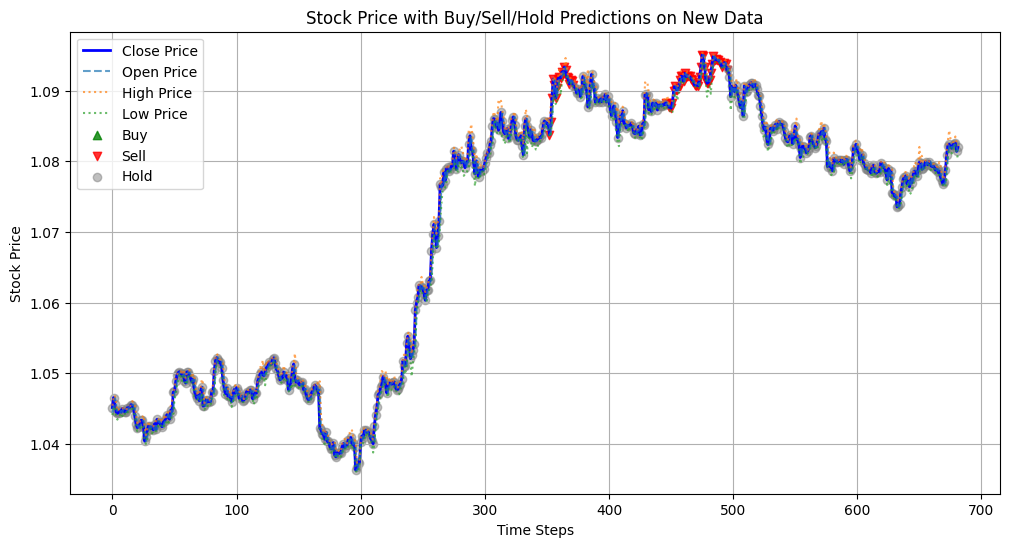

      Open     High      Low    Close Prediction
0  1.04440  1.04539  1.04406  1.04513       Hold
1  1.04515  1.04661  1.04509  1.04654       Hold
2  1.04655  1.04686  1.04530  1.04557       Hold
3  1.04556  1.04557  1.04382  1.04451       Hold
4  1.04451  1.04470  1.04342  1.04431       Hold
5  1.04430  1.04490  1.04397  1.04442       Hold
6  1.04440  1.04468  1.04407  1.04468       Hold
7  1.04464  1.04486  1.04437  1.04448       Hold
8  1.04448  1.04504  1.04393  1.04499       Hold
9  1.04497  1.04497  1.04441  1.04471       Hold


C:\Users\Teacher\AppData\Local\Temp\ipykernel_8552\386146282.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Prediction"] = new_pred_series.map({0: "Hold", -1: "Sell", 1: "Buy"})


In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Predict Buy/Sell/Hold Signals
new_predictions = mlp_model.predict(features_new)
new_pred_classes = np.argmax(new_predictions, axis=1)  # Convert probabilities to class labels

# Correct Label Mapping (Ensures consistency)
label_mapping = {2: 1, 1: -1, 0: 0}  # Convert back to Buy=1, Sell=-1, Hold=0
new_pred_series = pd.Series(new_pred_classes, index=new_df.index).map(label_mapping)

# Plot OHLC Data
plt.figure(figsize=(12, 6))
plt.plot(new_df.index, new_df["Close"], label='Close Price', color='blue', linewidth=2)
plt.plot(new_df.index, new_df["Open"], label='Open Price', linestyle='dashed', alpha=0.7)
plt.plot(new_df.index, new_df["High"], label='High Price', linestyle='dotted', alpha=0.7)
plt.plot(new_df.index, new_df["Low"], label='Low Price', linestyle='dotted', alpha=0.7)

# Find Buy, Sell, Hold signals
buy_signals = new_df.index[new_pred_series == 1]
sell_signals = new_df.index[new_pred_series == -1]
hold_signals = new_df.index[new_pred_series == 0]

# Plot Buy/Sell/Hold Markers
plt.scatter(buy_signals, new_df.loc[buy_signals, "Close"], marker='^', color='green', label='Buy', alpha=0.8)
plt.scatter(sell_signals, new_df.loc[sell_signals, "Close"], marker='v', color='red', label='Sell', alpha=0.8)
plt.scatter(hold_signals, new_df.loc[hold_signals, "Close"], marker='o', color='gray', label='Hold', alpha=0.5)

plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price with Buy/Sell/Hold Predictions on New Data")
plt.grid(True)
plt.show()

# Save Predictions
new_df["Prediction"] = new_pred_series.map({0: "Hold", -1: "Sell", 1: "Buy"})
new_df.to_csv("predicted_results_new.csv", index=False)

# Print first 10 rows
print(new_df.head(10))
